# Importing necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
import pathlib

import os

print(os.getcwd())
%cd ..
%cd gdrive
%cd My Drive
%cd PROJECT
#data_root = pathlib.Path("/gdrive/My Drive/PROJECT")

#%cd ./gdrive/My Drive/PROJECT
print(os.getcwd())

Mounted at /gdrive
/content
/
/gdrive
/gdrive/My Drive
/gdrive/My Drive/PROJECT
/gdrive/My Drive/PROJECT


In [ ]:
# We use predefined layers from pix2pix model for our unet upsampling architecture
pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time

import matplotlib
from matplotlib import pyplot as plt

from IPython.display import clear_output

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow_examples.models.pix2pix import pix2pix

import numpy as np

import pandas as pd

import cv2

from PIL import Image

# Data Loading and Processing

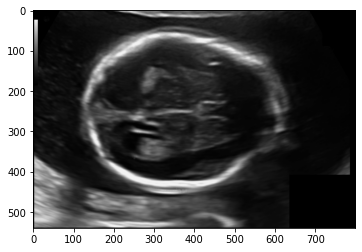

In [ ]:
# We open an ultrasound image
img=cv2.imread('train/images/363_HC.png')

plt.imshow(img[:,:,:])

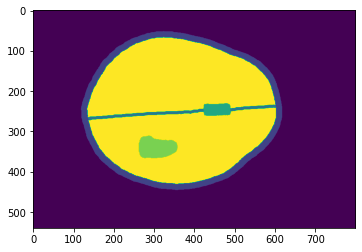

In [ ]:
# We open annotated image corresponding to the ultrasound image from previous cell
img=cv2.imread('train/labels/363_HC_Annotation.png')

plt.imshow(img[:,:,1],)

## Functions for loading and processing images and segmented labels


*   Only the ultrasound image is cast to float32, and the label images are int8.
*   Input ultrasound images are considered 3 channel images, whereas labels are 1 channel images.
*   Both images and labels are resized to 224*224.



In [ ]:
SHAPE = 224

def load(image_file,ch):
  image = tf.io.read_file(image_file)
  input_image = tf.image.decode_png(image,channels=ch)

  if ch==3:
    input_image = tf.cast(input_image, tf.float32)

  return input_image

def resize(input_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)


  return input_image



def load_image_train(image_file):
  input_image= load(image_file,ch=3)
  input_image= resize(input_image,SHAPE,SHAPE)
  input_image= (input_image / 255.0)

  return input_image

def load_mask_train(image_file):
  input_image= load(image_file,ch=1)
  input_image= resize(input_image,SHAPE,SHAPE)

  return input_image

In [ ]:
# Load training images and labels
trainimg = tf.data.Dataset.list_files(os.getcwd()+'/train/images/*.*',shuffle=False)
trainmask = tf.data.Dataset.list_files(os.getcwd()+'/train/labels/*.*',shuffle=False)

trainimg = trainimg.map(load_image_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)

trainmask = trainmask.map(load_mask_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Load validation images and labels
validimg = tf.data.Dataset.list_files(os.getcwd()+'/val/images/*.*',shuffle=False)
validmask = tf.data.Dataset.list_files(os.getcwd()+'/val/labels/*.*',shuffle=False)

validimg = validimg.map(load_image_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)

validmask = validmask.map(load_mask_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Load Testing images
testimg = tf.data.Dataset.list_files(os.getcwd()+'/test/images/*.*',shuffle=False)
testmask = tf.data.Dataset.list_files(os.getcwd()+'/test/images/*.*',shuffle=False)

testimg = testimg.map(load_image_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)

testmask = testmask.map(load_mask_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [ ]:
print(trainmask)

<ParallelMapDataset shapes: (224, 224, 1), types: tf.uint8>

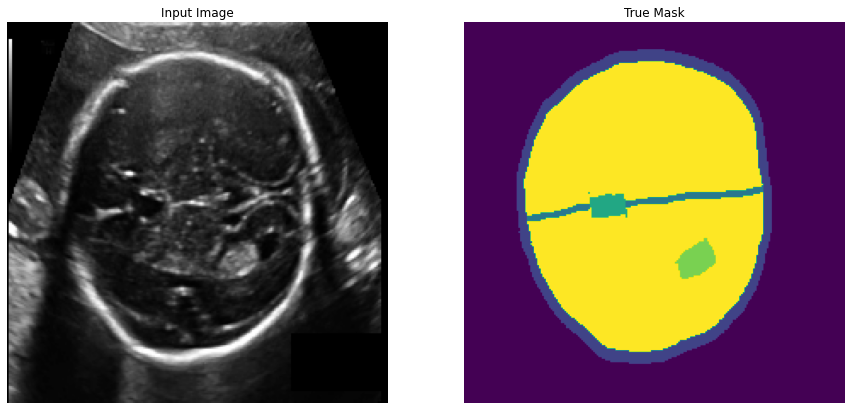

In [ ]:
# Checking weather the images are processed correctly
for image, mask in train_data.take(10):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Dataset Preparation

The ultrasound images and labels are zipped together in a single dataset for further use during model training and evaluation.

In [ ]:
BUFFER_SIZE = 100
BATCH_SIZE = 1

train_data = tf.data.Dataset.zip((trainimg,trainmask))
train_dataset = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

valid_data = tf.data.Dataset.zip((validimg,validmask))
valid_dataset = valid_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.data.Dataset.zip((testimg,testmask))
test_dataset = test_data.cache().batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Model

## Encoder

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project',
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

down_stack.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

## Decoder

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),

## Defining the model with skip connection architecture

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')

  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

## Complie model with optimizer and loss

In [ ]:
# We have 6 classes in our labels so we want 6 channels in out final output
output_classes=6
model = unet_model(output_classes)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

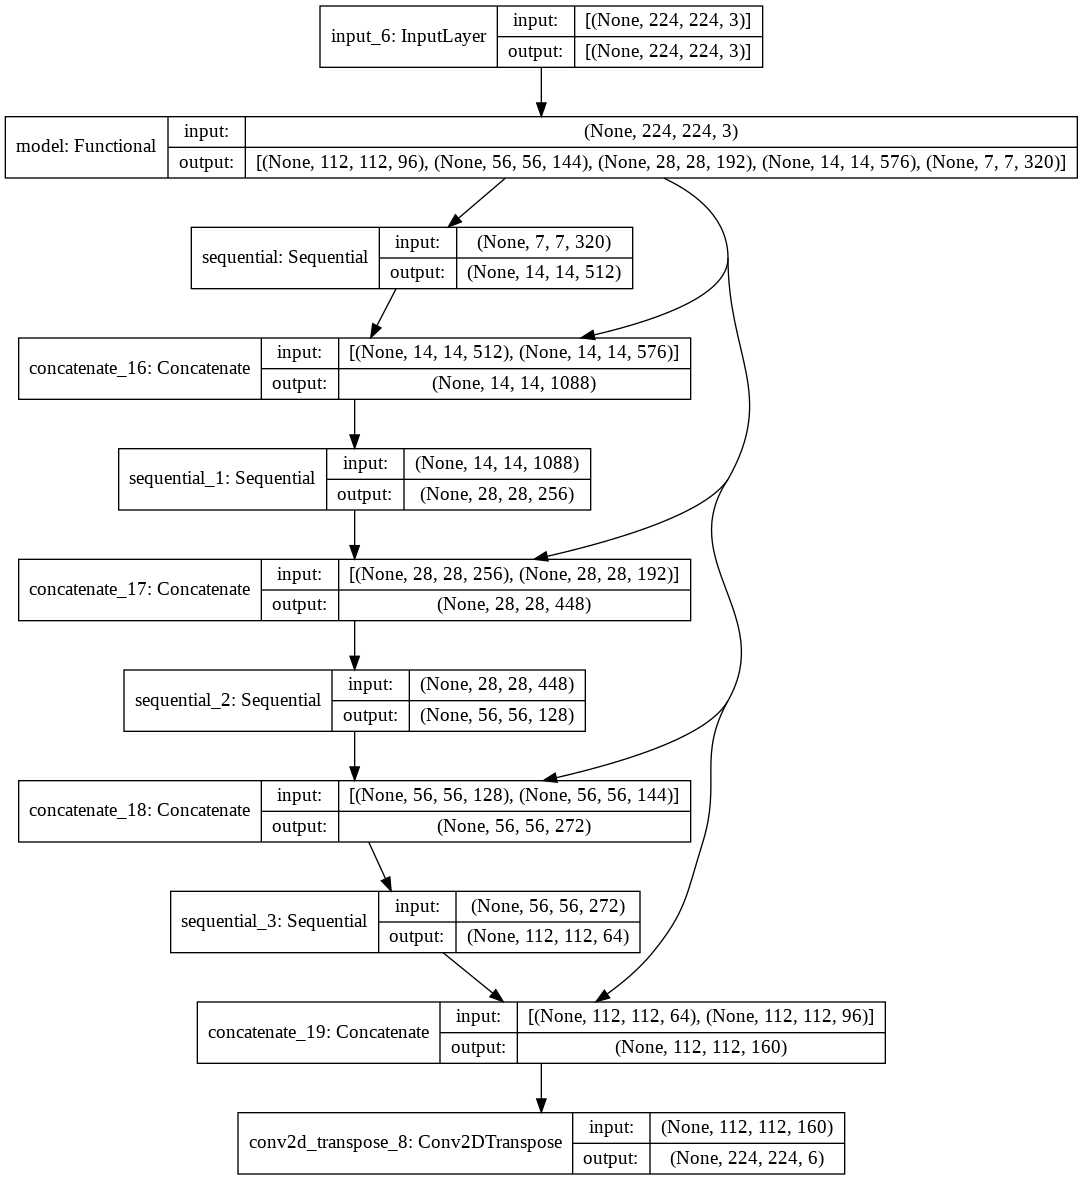

In [ ]:
# Model architecture
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# This function converts the 224 * 224 * 6 -> 224 * 224 * 1 with int values in places corresponding to the class labels
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

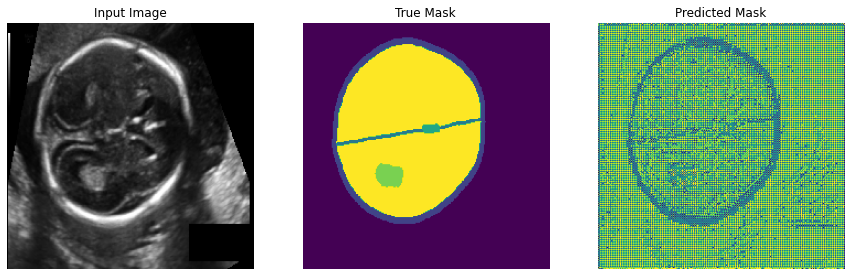

In [ ]:
# Result of predicted mask prior to training
show_predictions(train_dataset, 1)

# Train the Model

We train the model for 10 epochs due to GPU limitations

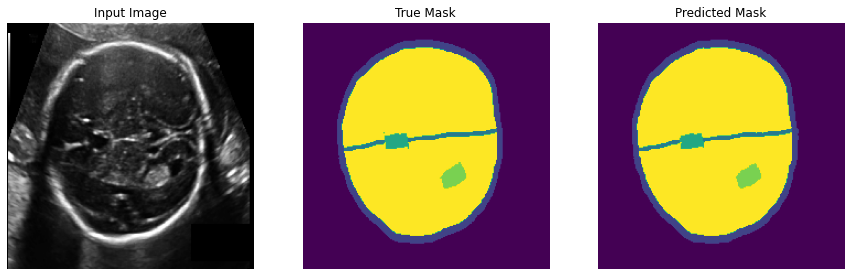


Sample Prediction after epoch 10



In [ ]:
EPOCHS = 10

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback()])

## Visualizing training and validation performance

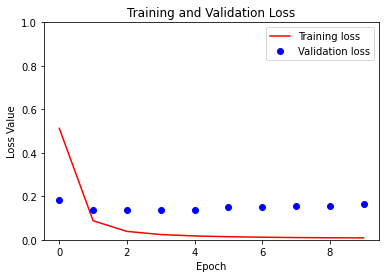

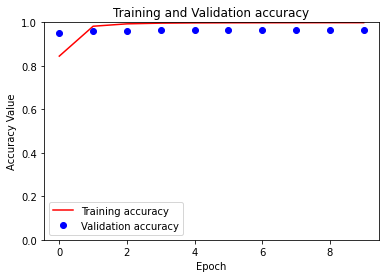

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

plt.figure()
plt.plot(model_history.epoch, accuracy, 'r', label='Training accuracy')
plt.plot(model_history.epoch, val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Making Predictions

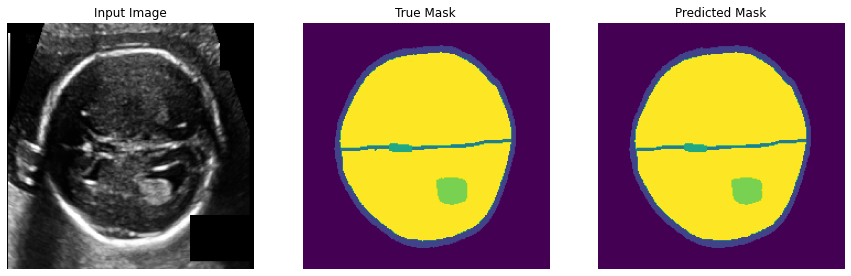

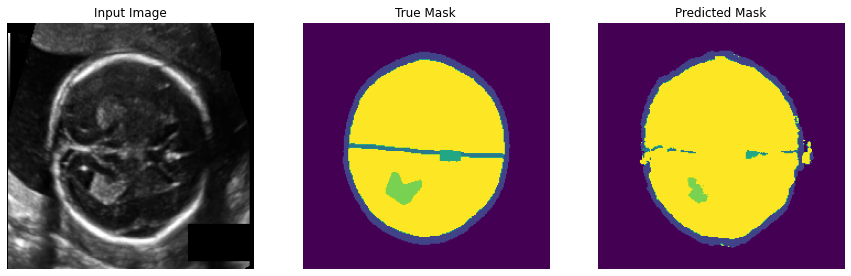

In [ ]:
# show_predictions()
show_predictions(valid_dataset, 2)

# Evaluating the model

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=6):
    dice=0
    for index in range(numLabels):
        y_true_idx=np.copy(y_true)
        y_true_idx[y_true!=index]=0
        y_true_idx[y_true==index]=1
        y_pred_idx=np.copy(y_pred)
        y_pred_idx[y_pred!=index]=0
        y_pred_idx[y_pred==index]=1
        dice += dice_coef(y_true_idx, y_pred_idx)
    return dice/numLabels # taking average

In [ ]:
# train_dataset.unbatch()
# valid_dataset.unbatch()

train_scores=[]
for img,mask in train_dataset.as_numpy_iterator():
  pred_mask = model.predict(img)
  act_mask=create_mask(pred_mask)
  dice_score = dice_coef_multilabel(mask[0], act_mask,6)
  train_scores.append(dice_score)

valid_scores=[]
for img,mask in valid_dataset.as_numpy_iterator():
  pred_mask = model.predict(img)
  act_mask=create_mask(pred_mask)
  dice_score = dice_coef_multilabel(mask[0], act_mask,6)
  valid_scores.append(dice_score)

print("Individual dice score for training set: ",train_scores)
print("Average dice score across training set: ",sum(train_scores)/len(train_scores))
print("\n")
print("Individual dice score for validation set: ",valid_scores)
print("Average dice score across validation set: ", sum(valid_scores)/len(valid_scores))

Individual dice score for training set:  [0.9695335926980192, 0.9645150347904479, 0.9749435006525872, 0.9832666255676653, 0.9923546240848381, 0.9797213524841885, 0.9883532040495906, 0.9864033991612313, 0.9903806914865587, 0.9915810401186654, 0.9878593296881811, 0.9858570957597538, 0.9906223875152264, 0.986183238293392, 0.98512374332857, 0.9613590822318049, 0.9887487324719316, 0.9881855664433332, 0.9901098199278823, 0.9857650482329379, 0.983219121267823, 0.9876082457197873, 0.9729157268290685, 0.9876807809223399, 0.9842047036058869, 0.9903467201868055, 0.9853444497484256, 0.9626288297251705, 0.98658197248486, 0.9877577043743885, 0.9888400609283615, 0.9886500321011589, 0.9828954879016596, 0.9852736923870201, 0.983194103951689, 0.9862497329748644, 0.9797138515233729, 0.9829165011889467, 0.9866601791898773, 0.9770126997791243, 0.9849405361569462, 0.99182014077476, 0.9689796891883793, 0.9903251067654454, 0.9883734282430129, 0.9885949485747721, 0.9886177570761112, 0.9892275937690003, 0.99228

# Predicting labels for test set

int64


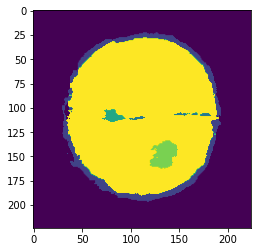

int64


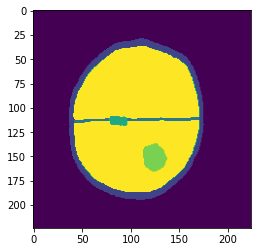

int64


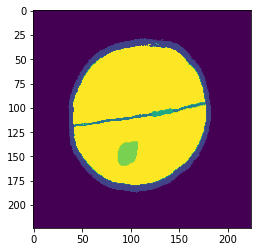

int64


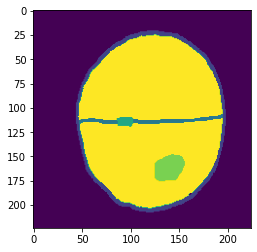

int64


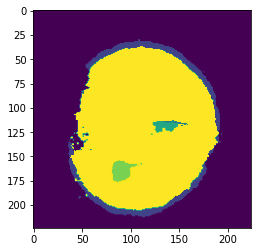

int64


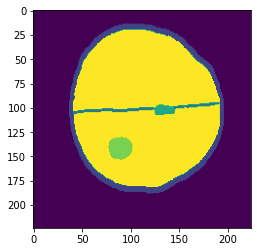

int64


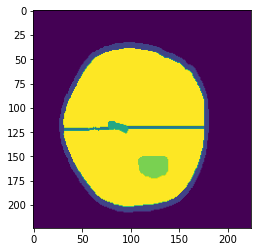

int64


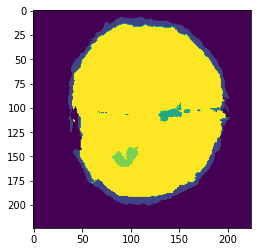

int64


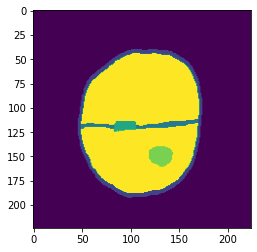

int64


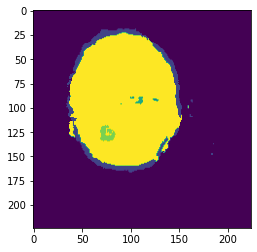

int64


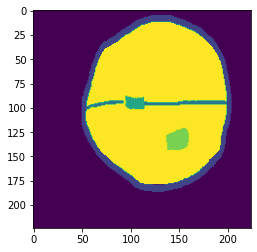

int64


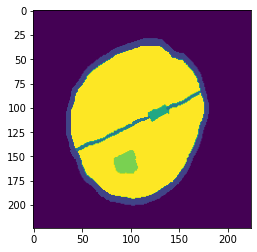

int64


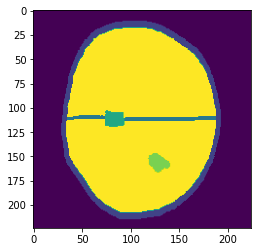

In [ ]:
i=0
for img,mask in test_dataset.as_numpy_iterator():
  pred_mask = model.predict(img)
  act_mask=create_mask(pred_mask)
  act_mask=act_mask.numpy()
  print(act_mask.dtype)
  tmp=Image.fromarray(act_mask.reshape((224,224)).astype(np.uint8))
  plt.imshow(tmp)
  plt.show()
  tmp.save('test/labels/'+str(i)+'.png')
  # fig=plt.figure()
  # plt.axis('off')
  # plt.imshow(act_mask[:,:,0])
  # fig.savefig('test/labels/'+str(i)+'.png', bbox_inches='tight', pad_inches=0)
  # plt.show()

  i+=1


[5 5 5]


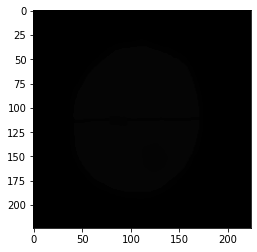

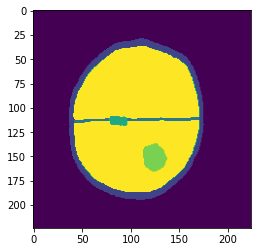

In [ ]:
# Result from test preditions
img=cv2.imread('test/labels/1.png')
print(img[100][100])
plt.imshow(img)
plt.show()
plt.imshow(img[:,:,0])
plt.show()

# Adding class weights

We use different class weights to in order to improve results of important aspects of the ultrasound image.

BACKGROUND : 1

CRANIUM : 2

MIDLINE_FALX : 2

CSP : 3

CHOROID_PLEXUS : 3

BRAIN_PARENCHYMA : 1

CSP and CHOROID_PLEXUS are given heighest weights as they are small in size and their relative importance in medical terms is higher than the rest of the segments.

In [ ]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1.0, 2.0, 2.0 , 3.0, 3.0 ,1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [ ]:
model = unet_model(6)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

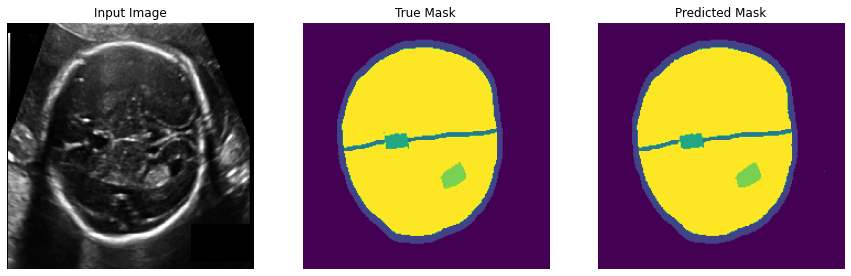


Sample Prediction after epoch 10



In [ ]:
model.fit(
    train_dataset.map(add_sample_weights),
    epochs=10,validation_data=valid_dataset,
                          callbacks=[DisplayCallback()])

In [ ]:
train_scores=[]
for img,mask in train_dataset.as_numpy_iterator():
  pred_mask = model.predict(img)
  act_mask=create_mask(pred_mask)
  dice_score = dice_coef_multilabel(mask[0], act_mask,6)
  train_scores.append(dice_score)

valid_scores=[]
for img,mask in valid_dataset.as_numpy_iterator():
  pred_mask = model.predict(img)
  act_mask=create_mask(pred_mask)
  dice_score = dice_coef_multilabel(mask[0], act_mask,6)
  valid_scores.append(dice_score)

print("Individual dice score for training set: ",train_scores)
print("Average dice score across training set: ",sum(train_scores)/len(train_scores))
print("\n")
print("Individual dice score for validation set: ",valid_scores)
print("Average dice score across validation set: ", sum(valid_scores)/len(valid_scores))

Individual dice score for training set:  [0.9757010222589596, 0.9814382294997658, 0.984354393621734, 0.9865665019996818, 0.9872550600010747, 0.9847005525115877, 0.9848067472406014, 0.9709785948698162, 0.9857600213344276, 0.9764891258335499, 0.9879942837210093, 0.98397705322682, 0.9816244629547656, 0.9874993505514685, 0.9860177134923469, 0.9894761562140876, 0.9754801557234871, 0.987365349007837, 0.98524398694996, 0.9825439610020988, 0.9815616675249407, 0.9794981264470818, 0.9695030238090544, 0.9837700485709132, 0.9786978529432359, 0.9882736845895831, 0.9852132286480523, 0.9705629581552192, 0.9888876174263768, 0.9849607278329958, 0.9885611848692767, 0.9774356083611545, 0.9856378317107768, 0.985845601077575, 0.9841995310616718, 0.978770934240882, 0.9867792074996514, 0.9868677393841679, 0.9880788379708139, 0.9843769388055045, 0.9850328807248373, 0.9848965181016597, 0.9868374540314612, 0.984388150556903, 0.9847941692310617, 0.9841097314815902, 0.9812514865813236, 0.9821156191456013, 0.98076

int64


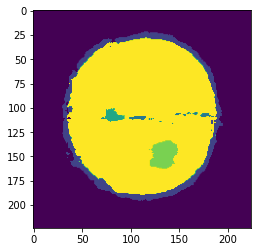

int64


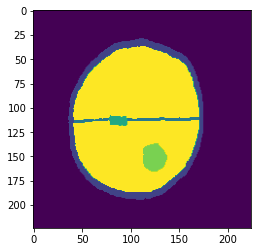

int64


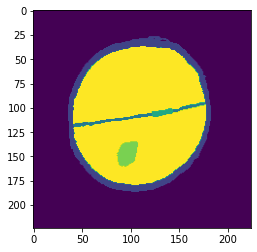

int64


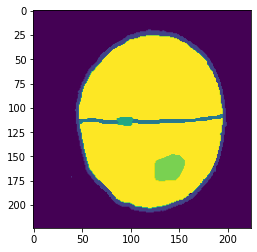

int64


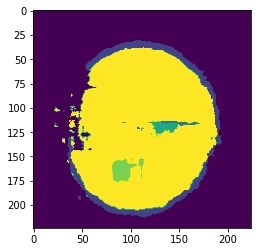

int64


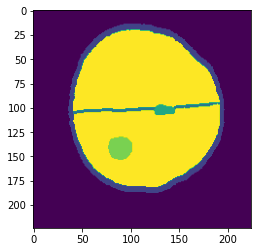

int64


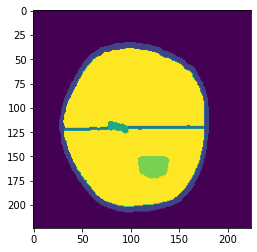

int64


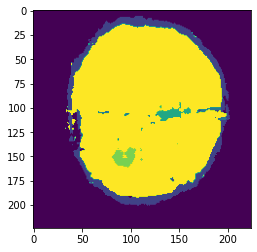

int64


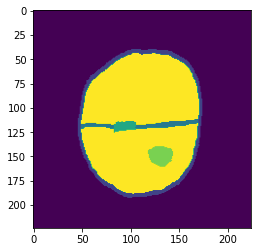

int64


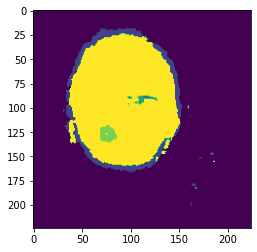

int64


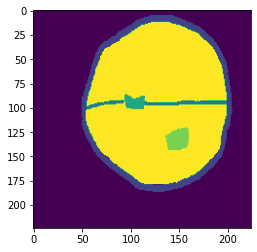

int64


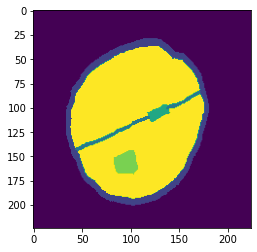

int64


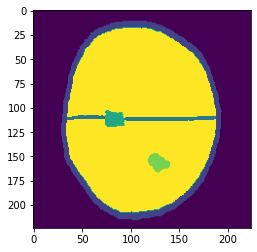

In [ ]:
i=0
for img,mask in test_dataset.as_numpy_iterator():
  pred_mask = model.predict(img)
  act_mask=create_mask(pred_mask)
  act_mask=act_mask.numpy()
  print(act_mask.dtype)
  tmp=Image.fromarray(act_mask.reshape((224,224)).astype(np.uint8))
  plt.imshow(tmp)
  plt.show()
  tmp.save('test/labelsweighted/'+str(i)+'.png')
  # fig=plt.figure()
  # plt.axis('off')
  # plt.imshow(act_mask[:,:,0])
  # fig.savefig('test/labels/'+str(i)+'.png', bbox_inches='tight', pad_inches=0)
  # plt.show()

  i+=1
